# Prototype constant-distance notebook

In [1]:
import lumicks.pylake as lk
import numpy as np
from matplotlib import pyplot as plt

VERBOSE = True  # show plots and other output along the way
DEBUG = True  # show some specific debugging information
CONFIG_FILE = ''  # filename of existing config, or empty string if we want to write one to 'estimates.json'
JOIN_SETS = True  # different fdcurves share the same fit. current notebook breaks if not True
OFFSET = 25  # number of datapoints to ignore before and after events
FIT_ON_RETURN = [200,600]  # if not empty, describes when after the return point to fit to
STARTING_FORCE = 0  # data is added to fit from the point where force > STARTING_FORCE

In [2]:
datasets = [{'filename': 'Data/adk5_curve1.h5', 'curve_ids': ['adk5_curve1']},
            {'filename': 'Data/adk5_curve2.h5', 'curve_ids': ['adk5_curve2']},
            {'filename': 'Data/adk5_curve3.h5', 'curve_ids': ['adk5_curve3']}]

In [3]:
fdcurves = {}
for dataset in datasets:
    data = lk.File(dataset['filename'])
    if JOIN_SETS:
        for curve_id in dataset['curve_ids']:
            fdcurves[curve_id] = {'curve': data.fdcurves[curve_id]}  # watch out for overlap in ids
    else:
        dataset['fdcurves'] = [data.fdcurves[curve_id] for curve_id in dataset['curve_ids']]

## Providing estimates

In [4]:
from build_config import bp2cl, write_config, read_config

Here we provide some initial guesses for the model parameters in a dictionary format that we write to a configuration file. If we already have a configuration file for this experimental setup, we can either skip this cell or set the CONFIG_FILE variable to the configuration file's name.

For each parameter, the possible entries are 'value', 'upper_bound', 'lower_bound' and 'fixed', where the latter fixes the parameter value to that in the 'value' field.

In [5]:
handle_estimates = \
    {'handles/Lp':  # DNA handle persistence length (nm)
      {'value': 15,  # initial estimate
       'upper_bound': 100,
       'lower_bound': 0.0},
     'handles/Lc':  # contour length (um)
      {'value': bp2cl(1040)},
     'handles/St':  # stretch modulus (pN)
      {'value': 300,
       'lower_bound': 250},
     'handles/f_offset':  # force offset (pN)
      {'value': 0,
       'upper_bound': 6,
       'lower_bound': -6,
       'fixed': True}
    }
protein_estimates = \
     {'protein/Lp':  # unfolded protein persistence length (nm)
      {'value': 0.7,
      'upper_bound': 1.0,
      'lower_bound': 0.6,
      'fixed': False}, #  if True, the estimate is fixed to the current 'value' field
     'protein/Lc':  # contour length (um)
      {'value': 0.01}  # maybe want something like aa2cl
     }

if not CONFIG_FILE:
    if VERBOSE:
        print('writing estimates.json')
    write_config('estimates.json', handle_estimates, protein_estimates)
elif VERBOSE:
    print(f'ignoring notebook estimates in favor of {CONFIG_FILE}')

writing estimates.json


In [6]:
estimates = read_config('estimates.json')
print(estimates)

{'handles': {'handles/Lp': {'value': 15, 'upper_bound': 100, 'lower_bound': 0.0}, 'handles/Lc': {'value': 0.3536}, 'handles/St': {'value': 300, 'lower_bound': 250}, 'handles/f_offset': {'value': 0, 'upper_bound': 6, 'lower_bound': -6, 'fixed': True}}, 'protein': {'protein/Lp': {'value': 0.7, 'upper_bound': 1.0, 'lower_bound': 0.6, 'fixed': False}, 'protein/Lc': {'value': 0.01}}}


## Event-finding
Here we try to find unfolding events, stationary/turning points, start-points and end-points

In [7]:
from event_finding import get_first_trough_index, find_transitions, plot_events

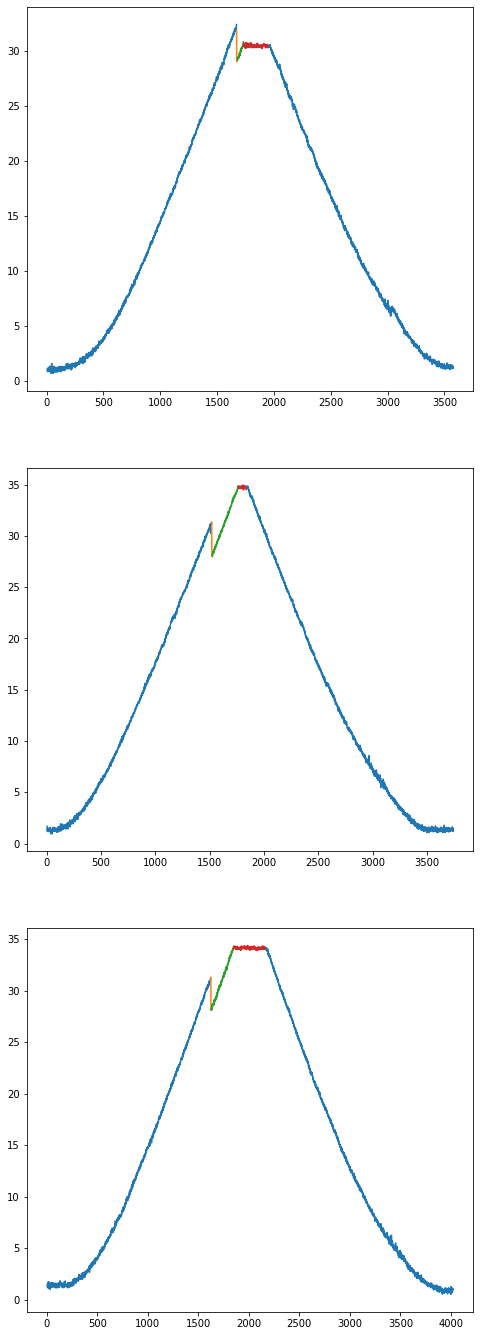

In [8]:
n_unfolds = 0
for key, val in fdcurves.items():
    curve = val['curve']
    top_window = (get_first_trough_index(curve.f.data, debug=DEBUG),
                  get_first_trough_index(curve.f.data, last=True, debug=DEBUG))
    if top_window[1] - top_window[0] > 100:   # stationary state is a good noise window
        unfolds, threshold = find_transitions(curve.f.data,
                                              noise_estimation_window = top_window)
    else:
        unfolds, threshold = find_transitions(curve.f.data)
    if len(unfolds) > n_unfolds:
        n_unfolds = len(unfolds)
    #print(unfolds)
    start = 0
    for index, force in enumerate(curve.f.data):
        if force > STARTING_FORCE:
            start = index
            break
    
    events = [start]
    events.extend(unfolds)
    events.append(top_window[0])
    legs = [slice(*[events[i] + OFFSET, events[i+1] - OFFSET]) \
            for i in range(len(events) - 1)]
    if FIT_ON_RETURN:
        legs.append(slice(*[top_window[-1] + FIT_ON_RETURN[0], top_window[-1] + sum(FIT_ON_RETURN)]))
        
    fdcurves[key]['start'] = start
    fdcurves[key]['top'] = top_window
    fdcurves[key]['unfolds'] = unfolds
    fdcurves[key]['threshold'] = threshold
    fdcurves[key]['legs'] = legs


if VERBOSE:
    plot_events(fdcurves)

## Error-finding
Here we try to filter out datasets based on multiple tethers, particle interference and bead loss.

... at some point

## Fitting and results

In [9]:
from util import load_estimates, extract_estimates
from copy import deepcopy

def load_estimates(fit, est):
    for param_key, param in est.items():
        for field_key in param.keys():
            if field_key == 'value':
                fit[param_key].value = param["value"]
            elif field_key == 'upper_bound':
                fit[param_key].upper_bound = param["upper_bound"]
            elif field_key == 'lower_bound':
                fit[param_key].lower_bound = param["lower_bound"]
            elif field_key == 'fixed':
                fit[param_key].fixed = param["fixed"]

Right now we only use the models below.

In [10]:
handles_model = lk.inverted_odijk("handles") \
    + lk.force_offset("handles")
composite_wrt_force = lk.odijk("handles") \
    + lk.inverted_marko_siggia_simplified("protein")
composite_model = composite_wrt_force.invert(interpolate=True,
                                             independent_min=0,
                                             independent_max=90) \
                  + lk.force_offset("handles")

# one composite model for each unfolded domain
compmodels = []
for i in range(n_unfolds):
    compmodels.append(deepcopy(composite_model))

In [11]:
fit = lk.FdFit(handles_model, *compmodels)
for key, val in fdcurves.items():
    curve = val['curve']
    first_leg = val['legs'][0]
    name = key
    fit[handles_model].add_data(f'{key}_handles',
                                curve.f.data[first_leg],
                                curve.d.data[first_leg])

load_estimates(fit, read_config('estimates.json')['handles'])
if DEBUG:
    print(extract_estimates(fit))
fit.fit()
if DEBUG:
    print(extract_estimates(fit))
if VERBOSE:
    print(fit)

fit['handles/St'].fixed = True
fit['handles/Lp'].fixed = True
fit['handles/Lc'].fixed = True

Fit
  - Model: handles_with_handles
  - Equation:
      f(d) = argmin[f](norm(handles.Lc * (1 - (1/2)*sqrt(kT/(f*handles.Lp)) + f/handles.St)-d)) + handles.f_offset

  - Data sets:
    - FitData(adk5_curve1_handles, N=1621)
    - FitData(adk5_curve2_handles, N=1469)
    - FitData(adk5_curve3_handles, N=1574)
  - Model: inv(handles_with_protein)_with_handles
  - Equation:
      f(d) = argmin[f](norm(handles.Lc * (1 - (1/2)*sqrt(kT/(d*handles.Lp)) + d/handles.St) + argmin[d](norm((1/4) * (1 - (d/protein.Lc))**(-2) - (1/4) + (d/protein.Lc)-d*protein.Lp/kT))-d)) + handles.f_offset

  - Data sets:

  - Fitted parameters:
    Name                   Value  Unit      Fitted      Lower bound    Upper bound
    ----------------  ----------  --------  --------  -------------  -------------
    handles/Lp         18.3601    [nm]      True                  0            100
    handles/Lc          0.352071  [micron]  True                  0            inf
    handles/St        269.679     [pN]      

In [12]:
for index, model in enumerate(compmodels):
    leg_index = index + 1
for key, val in fdcurves.items():
    curve = val['curve']
    unfold_legs = val['legs'][1:]
    for index, model in enumerate(compmodels):
        fit[model].add_data(f'{key}_domain_{index+1}',
                            curve.f.data[unfold_legs[index]],
                            curve.d.data[unfold_legs[index]])
        if len(compmodels) - index <= 2:
            fit[model].add_data(f'{key}_domain_{index+1}_return',
                            curve.f.data[unfold_legs[-1]],
                            curve.d.data[unfold_legs[-1]])

load_estimates(fit, read_config('estimates.json')['protein'])

In [16]:
fit.fit()

# if VERBOSE:
    # print(fit)

Name,Value,Unit,Fitted,Lower bound,Upper bound
handles/Lp,18.3601,[nm],False,0,100
handles/Lc,0.352071,[micron],False,0,inf
handles/St,269.679,[pN],False,250,inf
kT,4.11,[pN*nm],False,0,8
handles/f_offset,0,[pN],False,-6,6
protein/Lp,0.66088,[nm],True,0.6,1
protein/Lc,0.0246523,[micron],True,0,inf


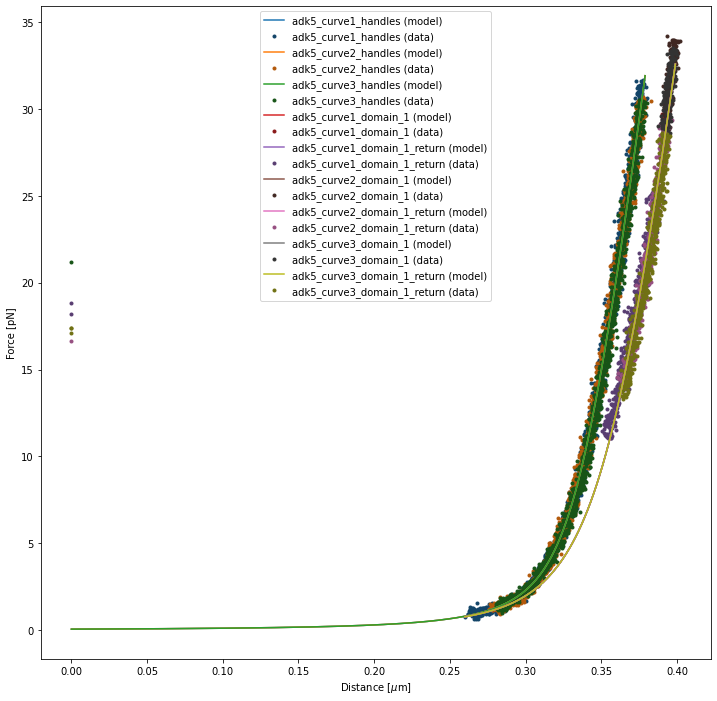

In [14]:
plt.figure(figsize=(12,12))
fit[handles_model].plot(independent=np.arange(0,0.38,0.001))
fit[compmodels[0]].plot(independent=np.arange(.26, .4, .001))
plt.ylabel('Force [pN]')
plt.xlabel('Distance [$\mu$m]')
plt.savefig("fits.png")
plt.show()
plt.close()


In [15]:
print(fdcurves['adk5_curve1'])

{'curve': <lumicks.pylake.fdcurve.FDCurve object at 0x7fdb67729880>, 'start': 0, 'top': (1731, 1955), 'unfolds': array([1671]), 'threshold': -1.0160184829329169, 'legs': [slice(25, 1646, None), slice(1696, 1706, None), slice(2155, 2755, None)]}
